In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import os
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

 import data from json

In [3]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()

A function to read data and create dataframe

In [4]:
def get_data():
    
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    n_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        n_data = n_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return n_data

Let us retrieve first 5 rows from above data set

In [5]:
newyork_data=get_data()
newyork_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
newyork_data.shape

(306, 4)

In [7]:
newyork_data.size

1224

Let us visualize which borough versus neighbours distribution.

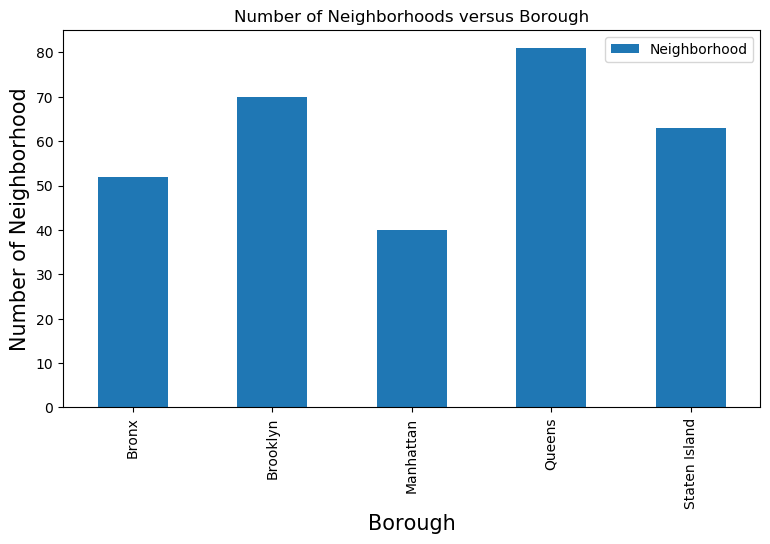

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods versus Borough')
#On x-axis
plt.xlabel('Borough Name', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhood', fontsize=15)
#giving a bar plot
newyork_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Next step is to figureout indian restuarants location. get_venues function returns venue id , name, category


In [22]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID ='S1G24XERWX3OSNWAINKYJ4IBH21OWGCQCVQXVKY0EHL4YTYH' # your Foursquare ID
    CLIENT_SECRET = 'PCSFKDRCUXAJ431YDQ4LOZFTD0TPEWRB21BRT321VZEEZJZG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
     # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [25]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'S1G24XERWX3OSNWAINKYJ4IBH21OWGCQCVQXVKY0EHL4YTYH' # your Foursquare ID
    CLIENT_SECRET = 'PCSFKDRCUXAJ431YDQ4LOZFTD0TPEWRB21BRT321VZEEZJZG' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Collecting venues details which are Indian Restaurants

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in newyork_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


Indian Resturants in Wakefield, Bronx:0
Indian Resturants in Co-op City, Bronx:0
Indian Resturants in Eastchester, Bronx:0
Indian Resturants in Fieldston, Bronx:0
Indian Resturants in Riverdale, Bronx:1
Indian Resturants in Kingsbridge, Bronx:1
Indian Resturants in Marble Hill, Manhattan:0
Indian Resturants in Woodlawn, Bronx:1
Indian Resturants in Norwood, Bronx:0
Indian Resturants in Williamsbridge, Bronx:0
Indian Resturants in Baychester, Bronx:0
Indian Resturants in Pelham Parkway, Bronx:0
Indian Resturants in City Island, Bronx:0
Indian Resturants in Bedford Park, Bronx:0
Indian Resturants in University Heights, Bronx:0
Indian Resturants in Morris Heights, Bronx:0
Indian Resturants in Fordham, Bronx:0
Indian Resturants in East Tremont, Bronx:0
Indian Resturants in West Farms, Bronx:0
Indian Resturants in High  Bridge, Bronx:0
Indian Resturants in Melrose, Bronx:0
Indian Resturants in Mott Haven, Bronx:0
Indian Resturants in Port Morris, Bronx:0
Indian Resturants in Longwood, Bronx

Indian Resturants in Ravenswood, Queens:1
Indian Resturants in Lindenwood, Queens:0
Indian Resturants in Laurelton, Queens:0
Indian Resturants in Lefrak City, Queens:0
Indian Resturants in Belle Harbor, Queens:0
Indian Resturants in Rockaway Park, Queens:0
Indian Resturants in Somerville, Queens:0
Indian Resturants in Brookville, Queens:0
Indian Resturants in Bellaire, Queens:1
Indian Resturants in North Corona, Queens:0
Indian Resturants in Forest Hills Gardens, Queens:0
Indian Resturants in St. George, Staten Island:0
Indian Resturants in New Brighton, Staten Island:1
Indian Resturants in Stapleton, Staten Island:0
Indian Resturants in Rosebank, Staten Island:0
Indian Resturants in West Brighton, Staten Island:0
Indian Resturants in Grymes Hill, Staten Island:0
Indian Resturants in Todt Hill, Staten Island:0
Indian Resturants in South Beach, Staten Island:0
Indian Resturants in Port Richmond, Staten Island:0
Indian Resturants in Mariner's Harbor, Staten Island:0
Indian Resturants in 

KeyError: 'groups'

In [27]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine


In [28]:
indian_rest_ny.shape

(126, 4)

126 restaurants in NewYork city

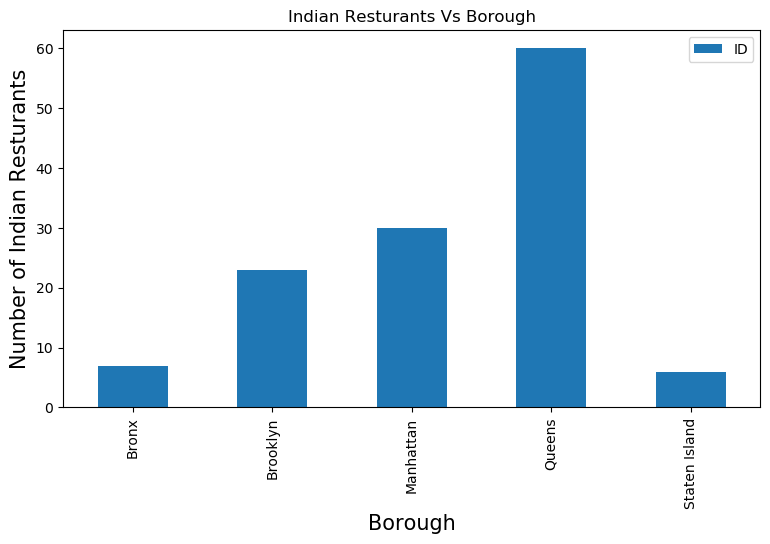

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Indian Resturants Vs Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can evidently see Queen has highest number of Indian Restaurants

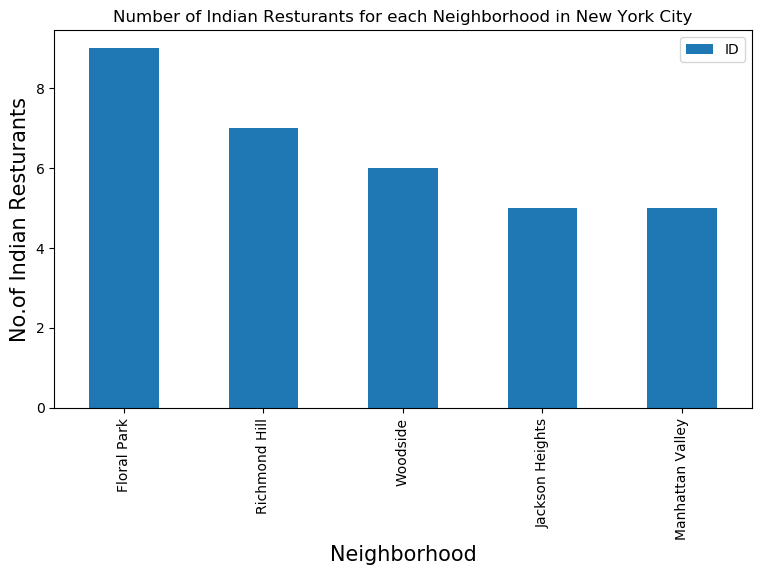

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park has highest number of Indian Restaurants

In [31]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
103,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
104,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
105,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
106,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
107,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
108,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
109,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
110,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


Queens Borough contains more number of restaurants


In [32]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 1 / 126 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 2 / 126 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     7.6    11
( 3 / 126 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 4 / 126 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.5     9
( 5 / 126 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 6 / 126 ) processed
                         ID             

KeyError: 'venue'

In [33]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.6,11
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9


In [34]:
indian_rest_ny.shape

(126, 4)

In [35]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [36]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [37]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [38]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
1,Bronx,Kingsbridge,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9
2,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,7.6,11
3,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
4,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.5,9


In [39]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [40]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [41]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [42]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [43]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.8
Tips                                 259
Name: 40, dtype: object

In [44]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                587
Rating                               9.1
Tips                                 146
Name: 44, dtype: object

In [45]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.8
Tips                                 259
Name: 40, dtype: object

In [46]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [47]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.1
32,West Village,8.9
11,Greenwich Village,8.9
17,Midtown,8.8
9,Fort Greene,8.7
3,Chelsea,8.7
18,Murray Hill,8.7
26,South Side,8.6
19,North Side,8.6
34,Yorkville,8.5


In [48]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [49]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.204348
1,Brooklyn,7.825000
0,Bronx,6.557143


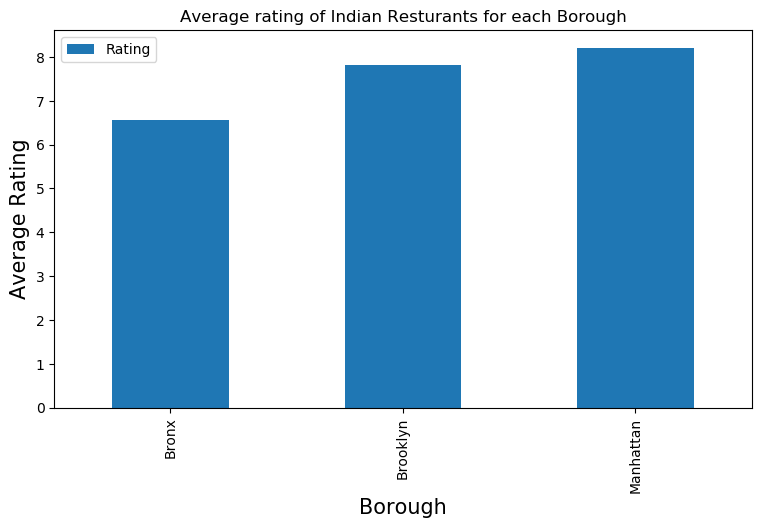

In [50]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [58]:
ny_neighborhood_stats

,Neighborhood,Average Rating
28,Tribeca,9.1


In [59]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,newyork_data, on='Neighborhood')

In [60]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [77]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Manhattan,Tribeca,40.721522,-74.010683,9.1,"Tribeca, Manhattan(9.1)"


In [78]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12, timeout=20)

In [79]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [80]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [81]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)